<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Custom Model in AtomAI: Autoencoders for Image Cleaning

*  *Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

*  *The simulated data (atomic coordinates) comes from MD calculations by Bobby Sumpter and Ayana Ghosh*

*  *Experimental (validation) data by Ondrej Dyck*



---


This notebook provides an example of training a custom Autoencoder for simple image cleaning (denoising) using [AtomAI](https://github.com/pycroscopy/atomai) trainers. Generally, autoencoders refer to the class of the neural networks that compress the data set to a small number of bottleneck features, and then expand back to original data size. The training aims to minimize information loss between the initial and reconstructed images via usual backpropagation. This process tends to select the relevant features in the data set and reject the noise, giving rise to applications for denoising.


---







Install AtomAI:

In [1]:
!pip install atomai

     |████████████████████████████████| 112kB 10.9MB/s 
     |████████████████████████████████| 194kB 16.5MB/s 
     |████████████████████████████████| 870kB 27.3MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174964 sha256=775a64d9f1d301cd9346133b0b2a9ab26491f9d762cfa20087e8102d4be4aece
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev


Imports:

In [2]:
import atomai as aoi
from atomai.nets import ConvBlock, UpsampleBlock
from atomai.utils import set_train_rng

import torch
import numpy as np
import matplotlib.pyplot as plt

Down(load) simulated data of graphene:

In [3]:
# Download into VM storage
!wget -O "graphene_MD_imgs.npy" https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1

--2021-02-05 05:08:53--  https://www.dropbox.com/s/r2cz8jqc9m19gaj/cropped_images_new.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy [following]
--2021-02-05 05:08:54--  https://www.dropbox.com/s/dl/r2cz8jqc9m19gaj/cropped_images_new.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc14d8d880f887839dcece9cc800.dl.dropboxusercontent.com/cd/0/get/BIViaeVug2NjjHtcKb0SadF1qtEmHCz7DRSuIl6L9wjaC2CAzbc2SuAzXGJvWgHNUgbTQna_D4-LW2HfcMmjcysVM21cY2KNWjNzv5LEBNoQGTOSzWuDkUPV7bESMSNFtDs/file?dl=1# [following]
--2021-02-05 05:08:54--  https://uc14d8d880f887839dcece9cc800.dl.dropboxusercontent.com/cd/0/get/BIViaeVug2NjjHtcKb0SadF1qtEmHCz7DRSuIl6L9wjaC2CAzbc2SuAzXGJvWgHNUgbTQna_D4-L

Load data into the notebook:


In [4]:
imgdata = np.load("graphene_MD_imgs.npy")[::3] # take ~1/3 of the data
print(imgdata.shape)

(2016, 256, 256)


Now let's corrupt our data with noise and then use a denoising autoencoder to reconstruct the original images.

In [5]:
np.random.seed(42) # for reproducibility
# Add noise to data
imgdata_noisy = imgdata + np.random.normal(scale=8, size=imgdata.shape)

View selected pairs of images (images from the left subplot will be inputs into a neural network and images from the right subplot will be our targets)

Text(0.5, 1.0, 'Original image')

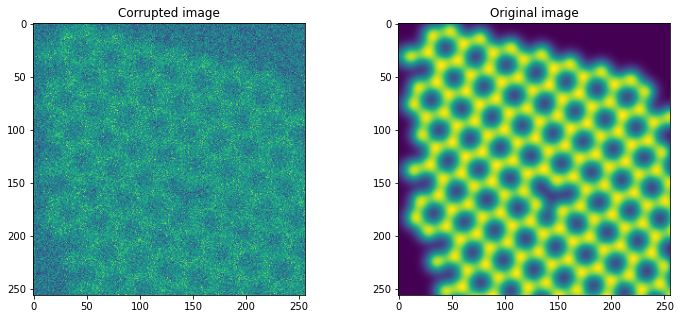

In [6]:
k = 15

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(imgdata_noisy[k])
ax2.imshow(imgdata[k])
ax1.set_title("Corrupted image")
ax2.set_title("Original image")

Use AtomAI's utility function to convert to the format used by PyTorch:

In [7]:
(imgdata, imgdata_noisy,
 imgdata_test, imgdata_noisy_test)  = aoi.utils.data_split(
     imgdata, imgdata_noisy, format_out="torch_float", channel="first")

Here we define our [denosing autoencoder](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder_(DAE)) by combining AtomAI's building blocks for neural networks and native PyTorch modules:

In [8]:
torch_encoder = torch.nn.Sequential(
    ConvBlock(ndim=2, nb_layers=1, input_channels=1, output_channels=8, batch_norm=True),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 8, 16, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 16, 32, batch_norm=False),
    torch.nn.MaxPool2d(2, 2),
    ConvBlock(2, 2, 32, 64, batch_norm=False)  # technically, this is a "bottleneck layer"
)

torch_decoder = torch.nn.Sequential(
    UpsampleBlock(ndim=2, input_channels=64, output_channels=64, mode="nearest"), # bilinear mode is better but leads to uncontrolled randomness on CPU
    ConvBlock(2, 2, 64, 32, batch_norm=False),
    UpsampleBlock(2, 32, 32, mode="nearest"),  # we can also use it to reduce numbe of "channels"
    ConvBlock(2, 2, 32, 16, batch_norm=False),
    UpsampleBlock(2, 16, 16, mode="nearest"),
    ConvBlock(2, 1, 16, 8, batch_norm=False),
    torch.nn.Conv2d(8, 1, 1) # vanilla 2D convolutional layer without activation
)

torch_DAE = torch.nn.Sequential(torch_encoder, torch_decoder)

Next we initialize AtomAI's trainer and pass our model to it:

In [9]:
trainer = aoi.trainers.BaseTrainer()
trainer.set_model(torch_DAE)

Compile a trainer:

In [10]:
# The next three lines are to ensure that we start from the same state of the model every time
set_train_rng(1)
trainer._reset_weights()
trainer._reset_training_history()

trainer.compile_trainer(
    (imgdata_noisy, imgdata, imgdata_noisy_test, imgdata_test), # training data
    loss="mse", training_cycles=500, swa=True  # training parameters
)

Finally, we train our model:

Epoch 1/500 ... Training loss: 68.9254 ... Test loss: 65.0157 ... GPU memory usage: 3779/16130
Epoch 100/500 ... Training loss: 2.1962 ... Test loss: 2.3446 ... GPU memory usage: 3779/16130
Epoch 200/500 ... Training loss: 1.3163 ... Test loss: 1.489 ... GPU memory usage: 3779/16130
Epoch 300/500 ... Training loss: 0.9035 ... Test loss: 1.3594 ... GPU memory usage: 3779/16130
Epoch 400/500 ... Training loss: 0.8195 ... Test loss: 0.7596 ... GPU memory usage: 3779/16130
Epoch 500/500 ... Training loss: 1.0444 ... Test loss: 0.7401 ... GPU memory usage: 3779/16130
Model (final state) evaluation loss: 0.75
Performing stochastic weights averaging...
Model (final state) evaluation loss: 0.6919
Plotting training history


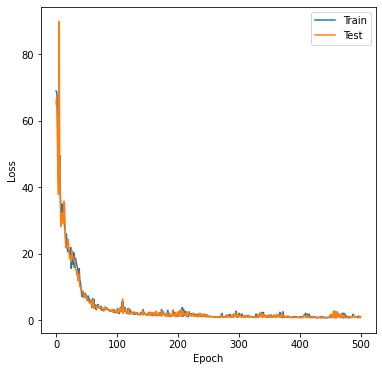

In [11]:
trained_model = trainer.run()

Make a prediction with the trained model using AtomAI's predictor class:

In [12]:
p = aoi.predictors.BasePredictor(trained_model, use_gpu=True)
prediction = p.predict(imgdata_noisy_test)

Text(0.5, 1.0, 'Difference')

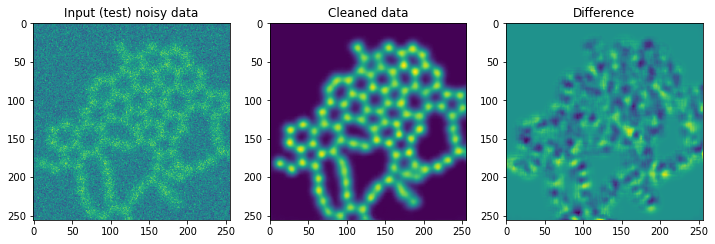

In [13]:
k = 50
# plot results
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
ax1.imshow(imgdata_noisy_test[k,0].cpu())
ax2.imshow(prediction[k,0].cpu())
ax3.imshow(imgdata_test[k,0].cpu() - prediction[k,0].cpu())
ax1.set_title("Input (test) noisy data")
ax2.set_title("Cleaned data")
ax3.set_title("Difference")

Looks clean!

Now we are going to gradually increase the noise level and see how well our model can generalize:

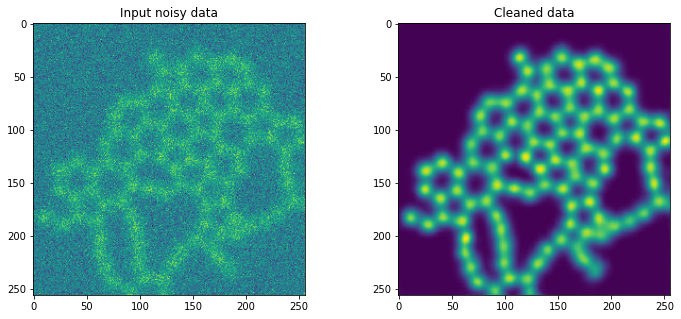

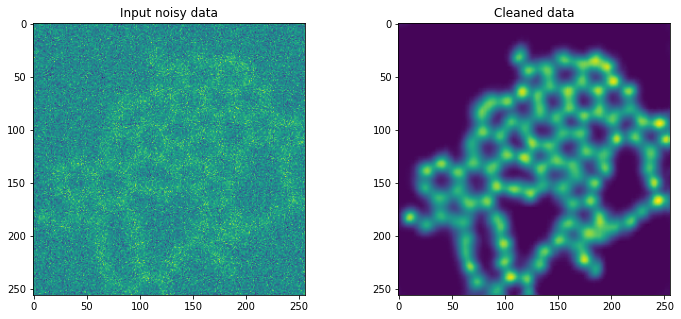

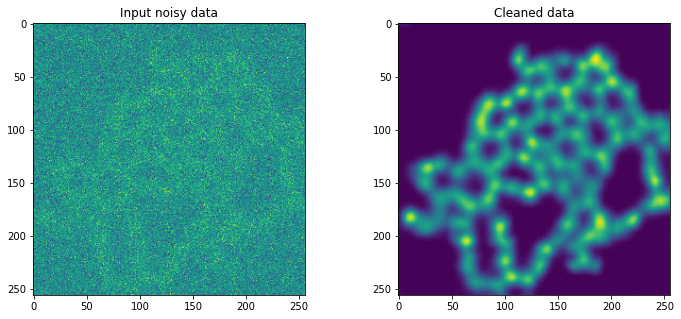

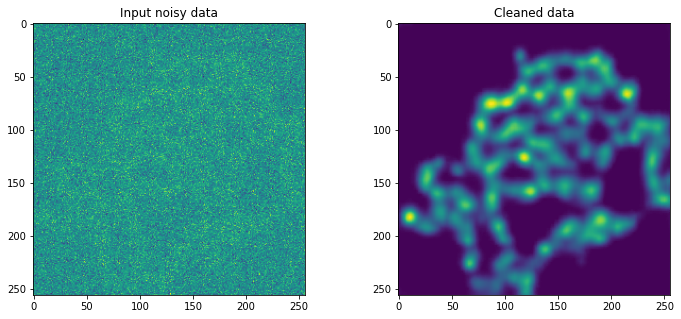

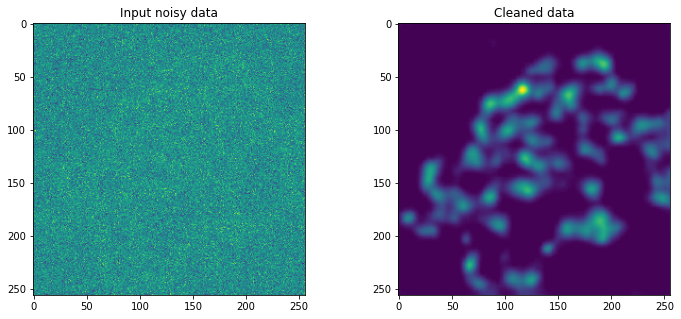

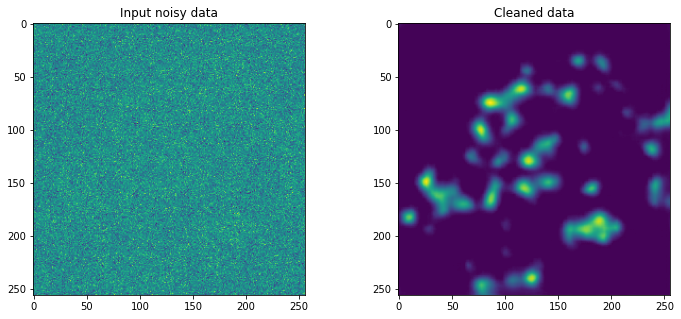

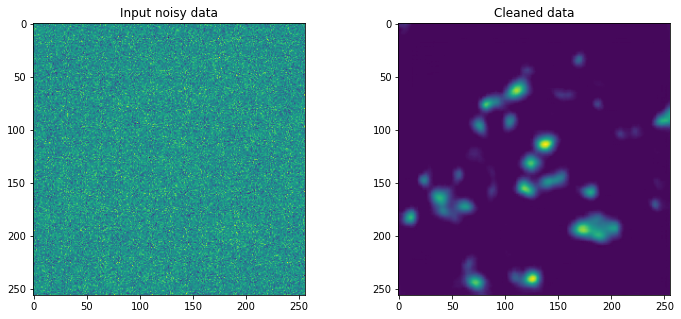

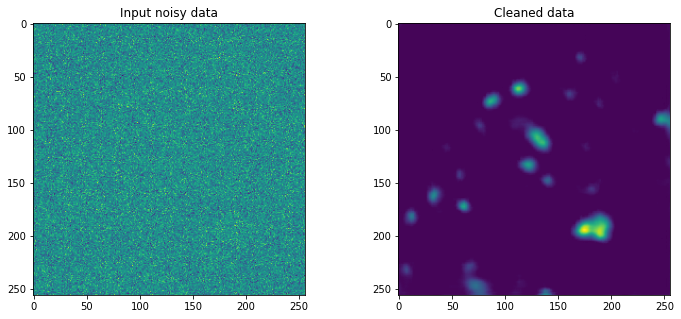

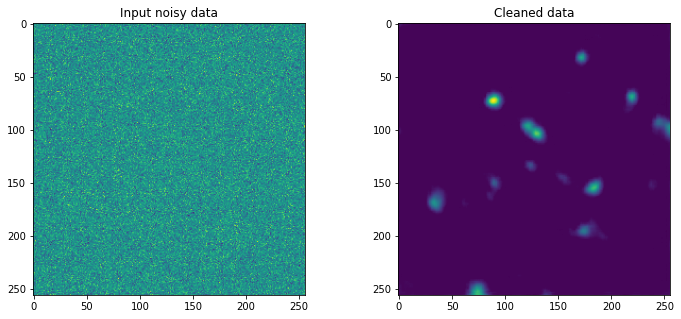

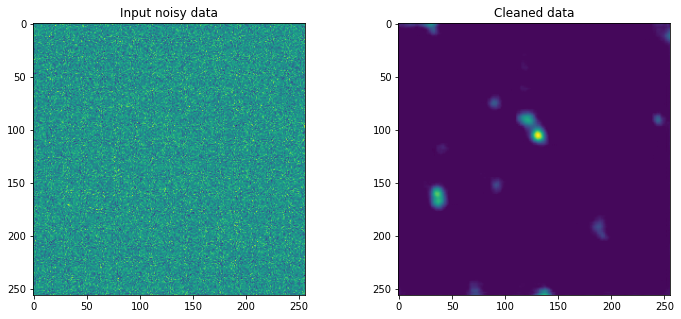

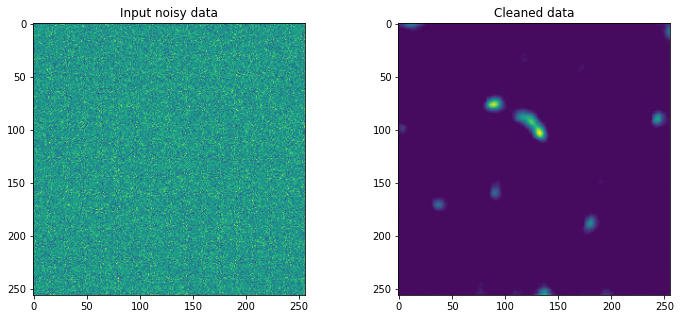

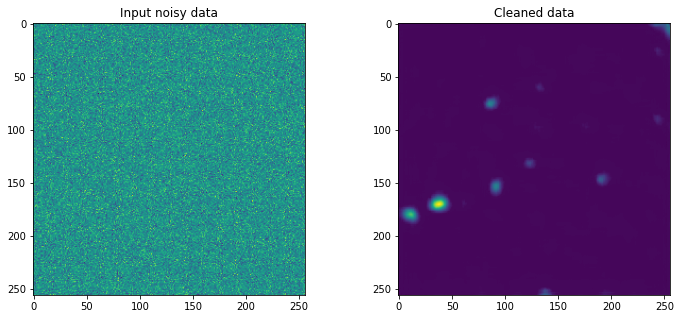

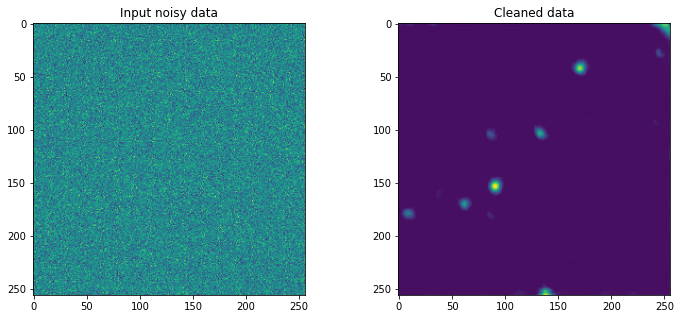

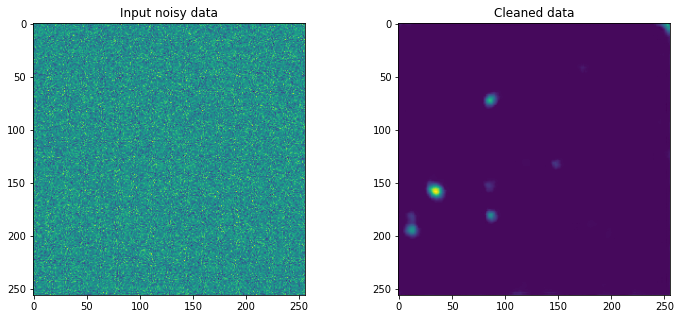

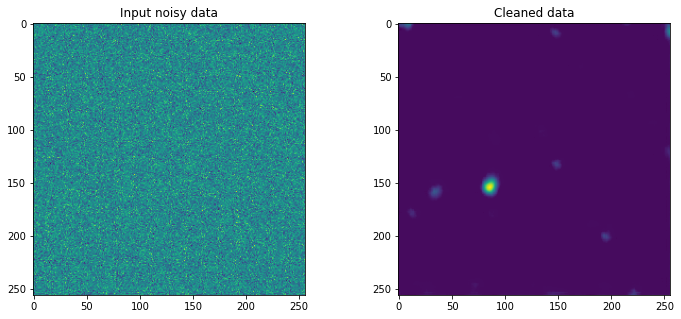

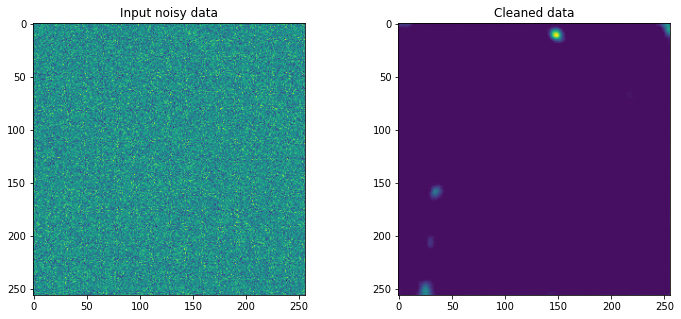

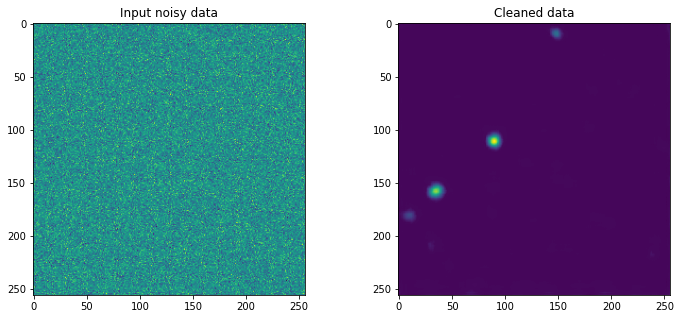

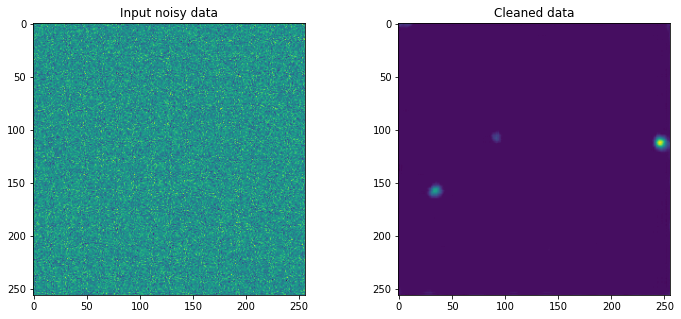

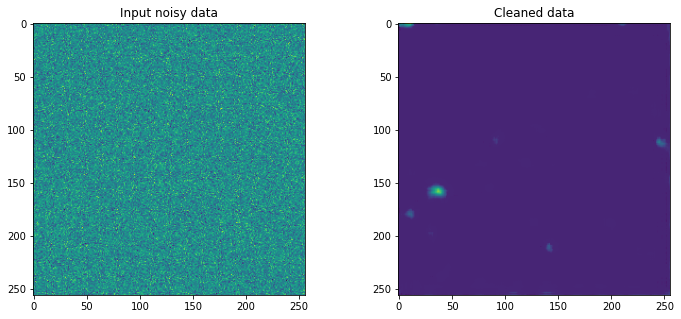

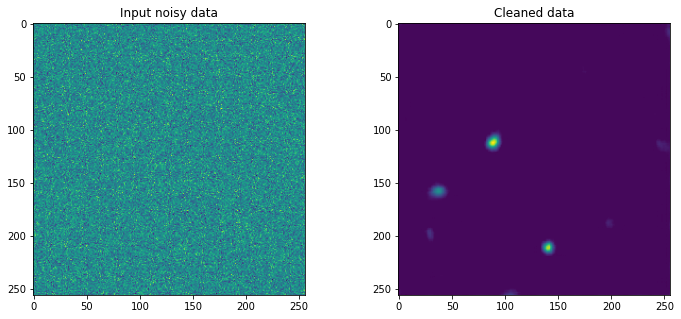

In [14]:
img = imgdata_test[k:k+1]
for s in range(0, 100, 5):
    img = img + np.random.normal(scale=8+s, size=img.shape).astype(np.float32)
    prediction = p.predict(img)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(img[0,0].cpu())
    ax2.imshow(prediction[0,0].cpu())
    ax1.set_title("Input noisy data")
    ax2.set_title("Cleaned data")
    plt.show()

Finally, let's apply it to experimental data. Note that the current model is by no means optimized to work with experimental data - we didn't even consider any scale changes. Still, it is interesting to see how it will perform on real-world data.

In [15]:
# download data
!wget -O "graphene_exp.npy" https://www.dropbox.com/s/33uo35z4siiy2y4/Gr_SiCr.npy?dl=1

--2021-02-05 05:13:40--  https://www.dropbox.com/s/33uo35z4siiy2y4/Gr_SiCr.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33uo35z4siiy2y4/Gr_SiCr.npy [following]
--2021-02-05 05:13:40--  https://www.dropbox.com/s/dl/33uo35z4siiy2y4/Gr_SiCr.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b0c6d4ef46f505efed213d457.dl.dropboxusercontent.com/cd/0/get/BIWsTveC-w6rG8ToFN2xh6TiJAktoLybTDfEng2MeS7wCqmWb1NODsq_CLpS54a7Q7SzP-n6AJTZ-6ArxhEitIDH6c8w6p4tGxWxUBY9LRrSwoX-soAksVWDg5LhKGRZTLM/file?dl=1# [following]
--2021-02-05 05:13:41--  https://uc2b0c6d4ef46f505efed213d457.dl.dropboxusercontent.com/cd/0/get/BIWsTveC-w6rG8ToFN2xh6TiJAktoLybTDfEng2MeS7wCqmWb1NODsq_CLpS54a7Q7SzP-n6AJTZ-6ArxhEitIDH6c8w6p4tGxWxUBY9LRrSw

In [16]:
expdata = np.load("graphene_exp.npy")
expdata = expdata * 60 # scale it to the range of pixel values used in training data

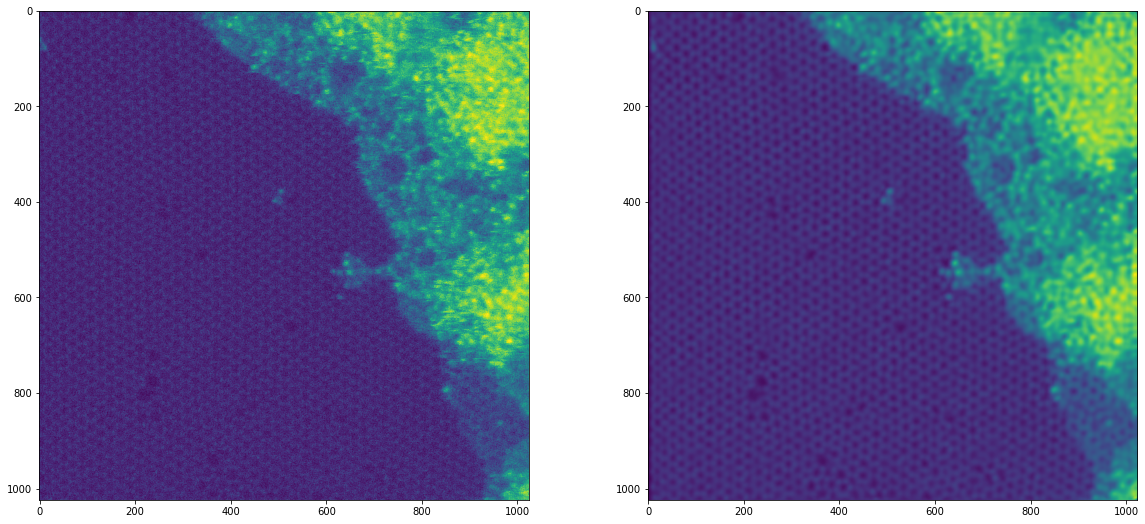

In [17]:
pred = p.predict(expdata[None, None])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(expdata)
ax2.imshow(pred.squeeze())

Looks like a decent predcition!